In [173]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import talib as ta
from matplotlib.animation import FuncAnimation
import pytz

[*********************100%***********************]  1 of 1 completed
--------                          Open       High        Low      Close  Adj Close  \
Datetime                                                                     
2023-01-10 14:09:00  89.000000  89.039200  88.980003  88.989998  88.989998   
2023-01-10 14:10:00  88.993599  89.000000  88.959999  88.980003  88.980003   
2023-01-10 14:11:00  88.985001  89.010002  88.964996  89.000000  89.000000   
2023-01-10 14:12:00  88.995499  89.089996  88.989998  89.050003  89.050003   
2023-01-10 14:13:00  89.070000  89.070000  88.959999  89.010002  89.010002   
...                        ...        ...        ...        ...        ...   
2023-01-11 15:56:00  92.245003  92.260002  92.180000  92.220001  92.220001   
2023-01-11 15:57:00  92.220001  92.239998  92.199997  92.214996  92.214996   
2023-01-11 15:58:00  92.209999  92.269997  92.199997  92.250000  92.250000   
2023-01-11 15:59:00  92.245003  92.320000  92.199997  92.239998  

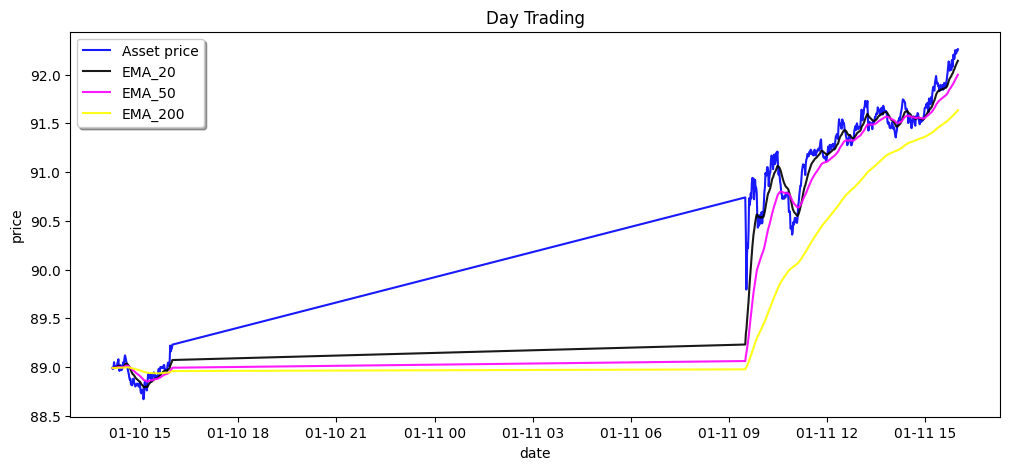

None


In [174]:
class MovingAverageDayTrading():

    def __init__(self, ticker, stop_loss=0.05, take_profit=0.1):
        self.ticker = ticker
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        # This way, when an instance of the class is created, the self.stop_loss and self.take_profit will be set with default values of 0.05 and 0.1 respectively. These values can be overridden when an instance of the class is created by passing a different value for stop_loss and take_profit.

    def moving_average_timeframes(self):
        
        #  QUERYING DATA --------------------------------------------

        end= datetime.today()
        start = end - timedelta(days=2)
        df = yf.download(self.ticker, start= start ,end= end, interval='1m')
        print(f'--------{df}__________')
        print(df.dtypes)
        print(f'index typeeeee : {df.index.dtype}')
        
        # check the interval of your dataframe by using the df.resample function with the same interval of data you want to work with
        ## df.resample('1min')

        #  SETTING UP DATA: ADDING COLUMNS FOR MA  --------------------------------------

        # Exponential Moving Averages
        df['EMA_20'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
        df['EMA_50'] = df['Adj Close'].ewm(span=50, adjust=False).mean()
        df['EMA_200'] = df['Adj Close'].ewm(span=200, adjust=False).mean()
        # the ewm() method to calculate the EMA, passing in the window size or span, which is the number of periods to use in the moving average. You can also adjust whether or not to apply some decay to the weights by adjusting the adjust parameter. By default is set to True, but it depends on the use case.
        
        
        # CLEANING DATA ------------------------------------------

        print(f'@@@@@@@@@@{df.columns}@@@@@@@@@@')
        print(df.dtypes)

        # check if the data is sorted correctly by running 
        df.sort_index(inplace=True)

        # Remove any rows with missing values
        df = df.dropna()
        # fill the empty spaces with what we want to fill it out
        df.fillna(method='ffill', inplace=True)

        # convert the index to the correct timezone using the pytz library
        # df.index = df.index.tz_localize('UTC').tz_convert('US/Eastern')

        df = df.between_time('09:30', '16:00', axis=0)
        
        # Filter the data to only include rows within trading hours
        df = df[(df.index.hour >= 9) & (df.index.hour <= 16)]
        # Remove any rows for weekends (Saturday and Sunday)
        df = df[df.index.weekday < 5]
        # Select only the columns of interest
        df = df[['Adj Close', 'EMA_20', 'EMA_50', 'EMA_200']]#,'SMA_20', 'SMA_50', 'SMA_200', 'BOL_upper','STO_slowk', 'RSI', 'MACD']]

        print(f'SHAPEEEEEEEEEEE  {df.shape}')

        
        if self.stop_loss is None or self.take_profit is None:
            raise ValueError("stop_loss and take_profit values must be set before using them")

        #  RISK MANAGEMENT // CHECKS BEFORE PLOTTING ----------------------------

        # buy = []
        # sell = []
        # for i in range(1, len(df)):
        #     # Check for buy signal
        #     if (df['EMA_20'][i] > df['EMA_50'][i] and df['EMA_20'][i-1] < df['EMA_50'][i-1]) and (df['EMA_20'][i] > df['EMA_200'][i] and df['EMA_20'][i-1] < df['EMA_200'][i-1]) and (df['SMA_20'][i] > df['SMA_50'][i] and df['SMA_20'][i-1] < df['SMA_50'][i-1]) and (df['SMA_20'][i] > df['SMA_200'][i] and df['SMA_20'][i-1] < df['SMA_200'][i-1]):
        #         buy.append((df.index[i], df['Adj Close'][i]))
        #         current_price = df['Adj Close'][i]
        #         stop_loss_price = current_price * (1 - self.stop_loss)
        #         take_profit_price = current_price * (1 + self.take_profit)
                
        #         # Implement stop loss and take profit
        #         for j in range(i, len(df)):
        #             if df['Adj Close'][j] < stop_loss_price:
        #                 sell.append((df.index[j], df['Adj Close'][j]))
        #                 break
        #             elif df['Adj Close'][j] > take_profit_price:
        #                 sell.append((df.index[j], df['Adj Close'][j]))
        #                 break
        #     # Check for sell signal   
        #     elif (df['EMA_20'][i] < df['EMA_50'][i] and df['EMA_20'][i-1] > df['EMA_50'][i-1]) and (df['EMA_20'][i] < df['EMA_200'][i] and df['EMA_20'][i-1] > df['EMA_200'][i-1]) and (df['SMA_20'][i] < df['SMA_50'][i] and df['SMA_20'][i-1] > df['SMA_50'][i-1]) and (df['SMA_20'][i] < df['SMA_200'][i] and df['SMA_20'][i-1] > df['SMA_200'][i-1]):
        #         sell.append((df.index[i], df['Adj Close'][i]))

        # PLOTTING WITH MATPLOTLIB -------------------------------------
        
        # plt.plot()
        plt.figure(figsize=(12,5))
        plt.xlabel("date")
        plt.ylabel("price")
        plt.plot(df['Adj Close'], label= 'Asset price', c='blue', alpha=0.9)
        plt.plot(df['EMA_20'], label='EMA_20', c='k', alpha= 0.9)
        plt.plot(df['EMA_50'], label='EMA_50', c='magenta', alpha= 0.9)
        plt.plot(df['EMA_200'], label='EMA_200', c='yellow', alpha= 0.9)
        
        
        # plt.scatter(df.iloc[buy].index,df.iloc[buy]['Adj Close'], marker='^', color='g', s=100)
        # plt.scatter(df.iloc[sell].index,df.iloc[sell]['Adj Close'], marker='v', color='r', s=100)

        plt.xlabel("date")
        plt.ylabel("price")
        plt.title('Day Trading')
        plt.legend(shadow=True)
        print("SHAPEESSSSSSSSSSS")
        print(df.index)
        print(df.columns)
        print(df['Adj Close'].shape)
        print(df['EMA_20'].shape)
        print(df['EMA_50'].shape)
        print(df['EMA_200'].shape)
        return plt.show()

        # df = pd.DataFrame(df.values.reshape(181,))

        # df = df.values.ravel()

if __name__ == '__main__':
    
    average = MovingAverageDayTrading('GOOG', stop_loss=0.03, take_profit=0.15)
    print(average.moving_average_timeframes())
    #     The function MovingAverageDayTrading("AAPL", stop_loss=0.03, take_profit=0.15) is an example of creating an instance of the MovingAverageDayTrading class and passing in the required parameters for the class.
    # Here, the string "AAPL" is passed as the value for the ticker attribute, and stop_loss and take_profit are set as 0.03 and 0.15 respectively.
    # You would use this line of code when you want to use the class to analyze "AAPL" stock and you have set stop_loss as 3% and take_profit as 15%.
    # You can replace "AAPL" with any other stock ticker of your choice and can change the stop_loss and take_profit as well as per your requirement.
    # It's important to note that this code will only work if the class MovingAverageDayTrading exists in the current environment and has the correct definition, including the constructor function with the parameters as described above.